# Accuracy-Size Tradeoff (QA HumanEval)
This notebook plots the "pass@1-kept_attn" and the "pass@1-kept_vrow" tradeoffs for Code Generation tasks that were ran. Top-k and Top-θeta are expected to show a drop in the pass@1 score as the number of kept attention or the number of kept V-rows decreases. 

Notebook usage: run the experiments, which will produce the results in the following directories
1. the directory "products" to contain the per-run directories (each named with a unique timestamp) each containing the per-layer "kept_attn" csv.gz files
2. in the directory "results-Llama", for each of the timestamps there should a an accuracy (acc_norm) result specified in one of the txt files 

To use this notebook, specify the list of runs' timestamps for which you would like to see the tradeoff plots under the `RESULTS_META_LIST` list

In [1]:
from data_util import ResultMeta, aggregate_accuracy_and_size_of_many_runs
from plot_util import plot_accuracy_vs_size

### LLaMA-3-8B Human-Eval
The results should be on aime02

In [2]:
# Read a list of runs (each run is uniquely identified by a timestamp) and specify a label for each run as it should appear in the plot
RESULTS_META_LIST = [
    ResultMeta(timestamp='2024-12-11_15-07-58_892894', label='Baseline', k=999),
    ResultMeta(timestamp='2024-12-11_14-13-06_861238', label='Top-θ pre-softmax + capk + vmc + exact-sdc', k=32, ),
    ResultMeta(timestamp='2024-12-11_22-54-47_733565', label='Top-θ pre-softmax + capk + vmc + exact-sdc', k=64, ),
    ResultMeta(timestamp='2024-12-12_06-52-19_767876', label='Top-θ pre-softmax + capk + vmc + exact-sdc', k=128,),
    ResultMeta(timestamp='2024-12-12_15-25-14_027529', label='Top-θ pre-softmax + capk + vmc + exact-sdc', k=256,),
    ResultMeta(timestamp='2024-12-12_23-22-52_652629', label='Top-θ pre-softmax + capk + vmc + exact-sdc', k=512,),
    ResultMeta(timestamp='2024-12-13_10-36-30_311126', label='Top-θ post-softmax + capk + vmc', k=32, ),
    ResultMeta(timestamp='2024-12-13_10-36-35_669164', label='Top-θ post-softmax + capk + vmc', k=64, ),
    ResultMeta(timestamp='2024-12-13_10-36-42_050172', label='Top-θ post-softmax + capk + vmc', k=128,),
    ResultMeta(timestamp='2024-12-13_10-36-48_951433', label='Top-θ post-softmax + capk + vmc', k=256,),
    ResultMeta(timestamp='2024-12-13_10-37-12_967832', label='Top-θ post-softmax + capk + vmc', k=512,),    
    ResultMeta(timestamp='2024-12-13_17-36-29_806131', label='Top-θ pre-softmax + vmc + exact-sdc', k=32, ),
    ResultMeta(timestamp='2024-12-13_20-37-04_993291', label='Top-θ pre-softmax + vmc + exact-sdc', k=64, ),
    ResultMeta(timestamp='2024-12-13_17-14-13_044280', label='Top-θ pre-softmax + vmc + exact-sdc', k=128,),
    ResultMeta(timestamp='2024-12-13_20-19-10_043860', label='Top-θ pre-softmax + vmc + exact-sdc', k=256,),
    ResultMeta(timestamp='2024-12-13_17-14-24_895654', label='Top-θ pre-softmax + vmc + exact-sdc', k=512,),
    ResultMeta(timestamp='2024-12-13_20-16-14_934315', label='Top-θ post-softmax + vmc', k=32, ),
    ResultMeta(timestamp='2024-12-13_17-14-35_167100', label='Top-θ post-softmax + vmc', k=64, ),
    ResultMeta(timestamp='2024-12-13_20-09-29_542432', label='Top-θ post-softmax + vmc', k=128,),
    ResultMeta(timestamp='2024-12-13_17-14-43_076583', label='Top-θ post-softmax + vmc', k=256,),
    ResultMeta(timestamp='2024-12-13_20-09-28_810509', label='Top-θ post-softmax + vmc', k=512,),        
    ResultMeta(timestamp='2024-12-11_14-11-48_484564', label='Top-k pre-softmax + vmc + exact-sdc',  k=32, ),
    ResultMeta(timestamp='2024-12-11_18-00-19_295944', label='Top-k pre-softmax + vmc + exact-sdc',  k=64, ),
    ResultMeta(timestamp='2024-12-11_22-58-24_689703', label='Top-k pre-softmax + vmc + exact-sdc',  k=128,),
    ResultMeta(timestamp='2024-12-12_05-41-32_420573', label='Top-k pre-softmax + vmc + exact-sdc',  k=256,),
    ResultMeta(timestamp='2024-12-12_14-52-55_962978', label='Top-k pre-softmax + vmc + exact-sdc',  k=512,),    
    ResultMeta(timestamp='2024-12-11_14-12-48_358250', label='Top-k post-softmax + vmc',  k=32, ),
    ResultMeta(timestamp='2024-12-11_17-42-41_422680', label='Top-k post-softmax + vmc',  k=64, ),
    ResultMeta(timestamp='2024-12-11_22-11-15_406841', label='Top-k post-softmax + vmc',  k=128,),
    ResultMeta(timestamp='2024-12-12_04-24-12_970125', label='Top-k post-softmax + vmc',  k=256,),
    ResultMeta(timestamp='2024-12-12_12-53-17_297919', label='Top-k post-softmax + vmc',  k=512,),
]

# Read the list of results - for the generative_decoding phase - focusing on "kept_vrow" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="generative_decoding"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_vrow"

df_humaneval_generative_decoding = aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


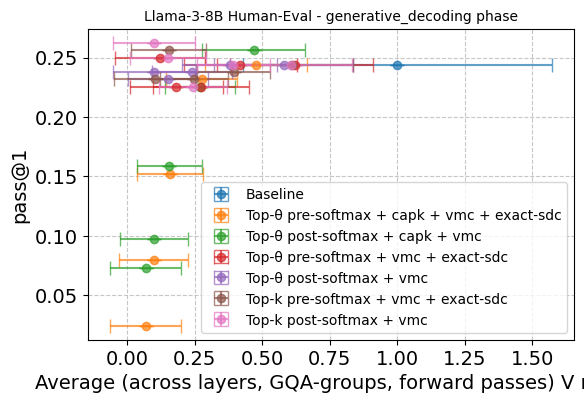

In [3]:
# plot inference with and without the capk - scatterplot with errorbars 
model_name = df_humaneval_generative_decoding.model_name.unique().item()
inference_phase = df_humaneval_generative_decoding.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_generative_decoding, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, GQA-groups, forward passes)",
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':10})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


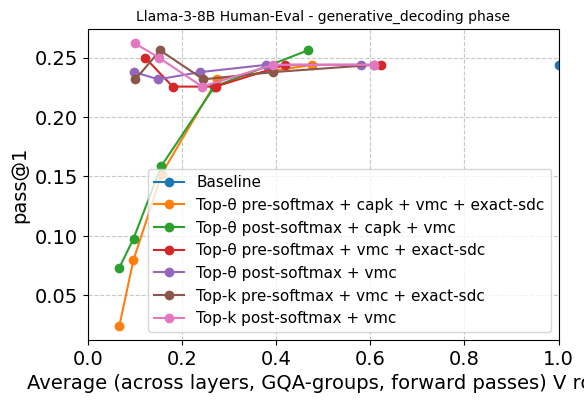

In [4]:
# plot inference with and without the capk - lineplots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_generative_decoding, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, GQA-groups, forward passes)",
                      plot_type='line',
                      rcParams_override={'legend.fontsize':11})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


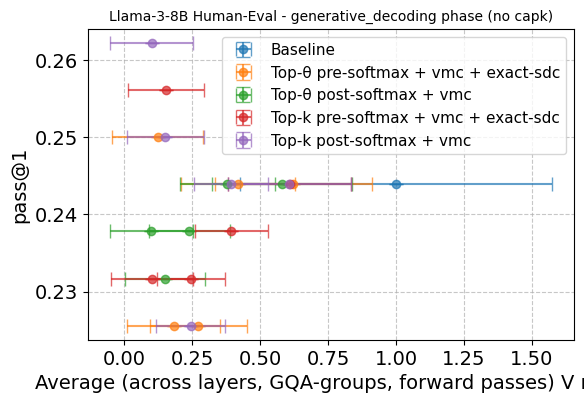

In [5]:
# plot generative decoding phase without the capk
model_name = df_humaneval_generative_decoding.model_name.unique().item()
inference_phase = df_humaneval_generative_decoding.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase (no capk)'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_generative_decoding[~df_humaneval_generative_decoding.label.str.contains('capk', case=False, na=False)], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, GQA-groups, forward passes)",
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':11})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


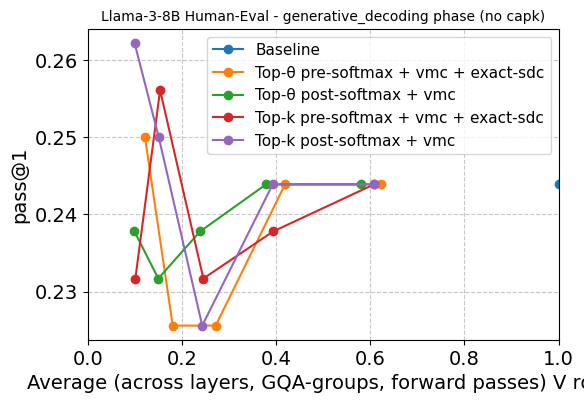

In [6]:
# plot inference without the capk - lineplots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_generative_decoding[~df_humaneval_generative_decoding.label.str.contains('capk', case=False, na=False)], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, GQA-groups, forward passes)",
                      plot_type='line',
                      rcParams_override={'legend.fontsize':11})

In [7]:
# Re-read the list of results - this time for the prefill phase - focusing on "kept_attn" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="prefill"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_attn"

df_humaneval_prefill= aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


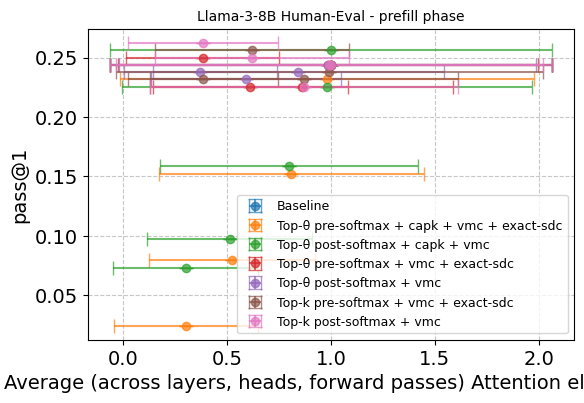

In [8]:
# plot prefill phase (with the capk) - scatterplots with errorbars
model_name = df_humaneval_prefill.model_name.unique().item()
inference_phase = df_humaneval_prefill.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_prefill, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, heads, forward passes)",
                      plot_type="errorbar",
                      rcParams_override={'legend.fontsize':9})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


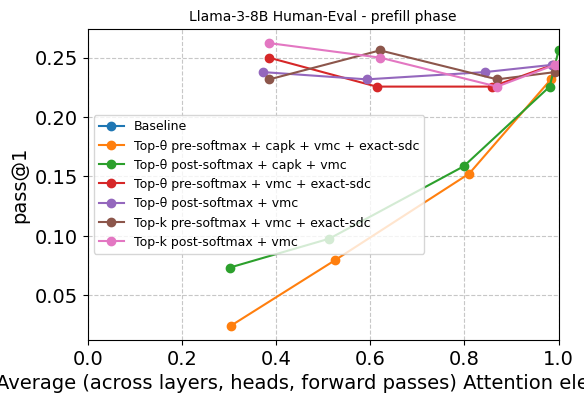

In [9]:
# plot inference without the capk - lineplots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_prefill, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, heads, forward passes)",
                      plot_type="line",
                      rcParams_override={'legend.fontsize':9})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


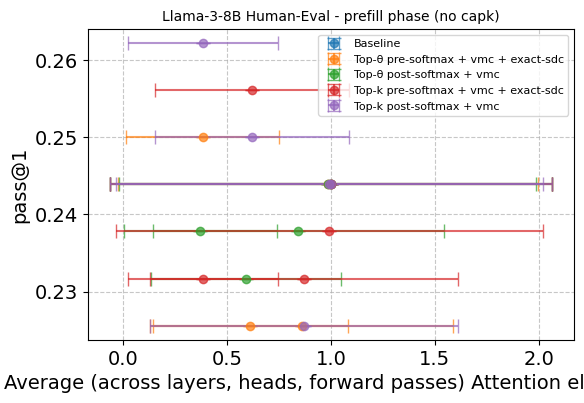

In [10]:
# plot inference without the capk - scatter plots with errorbars
model_name = df_humaneval_prefill.model_name.unique().item()
inference_phase = df_humaneval_prefill.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase (no capk)'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_prefill[~df_humaneval_prefill.label.str.contains('capk', case=False, na=False)], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, heads, forward passes)",
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':8})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


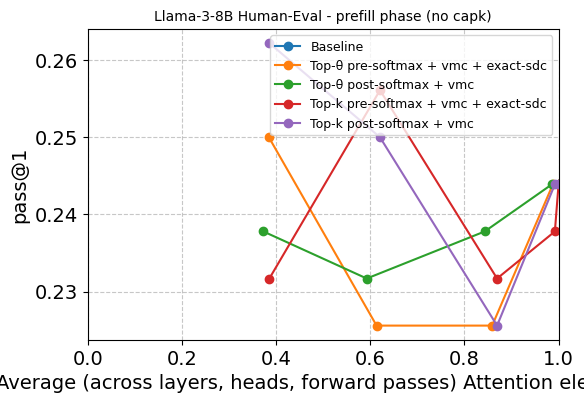

In [11]:
# plot inference without the capk - lineplots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_prefill[~df_humaneval_prefill.label.str.contains('capk', case=False, na=False)], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average (across layers, heads, forward passes)",
                      plot_type='line',
                      rcParams_override={'legend.fontsize':9})

### LLaMA-3-8B-Instruct Human-Eval
The results should be on aime02

In [2]:
# Read a list of runs (each run is uniquely identified by a timestamp) and specify a label for each run as it should appear in the plot
RESULTS_META_LIST = [
    ResultMeta(timestamp='2024-12-20_19-26-46_940925', label='Baseline', k=999),
    ResultMeta(timestamp='2025-01-08_13-59-23_324002', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=32, ),
    ResultMeta(timestamp='2025-01-08_13-59-31_130650', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=64, ),
    ResultMeta(timestamp='2025-01-08_13-59-19_033290', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=128,),
    ResultMeta(timestamp='2025-01-08_13-59-43_146373', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=256,),
    ResultMeta(timestamp='2025-01-08_13-59-51_603275', label='Top-θ(cal.arcc) post-softmax + vmc', k=32, ),
    ResultMeta(timestamp='2025-01-08_13-59-58_900733', label='Top-θ(cal.arcc) post-softmax + vmc', k=64, ),
    ResultMeta(timestamp='2025-01-08_14-00-05_326830', label='Top-θ(cal.arcc) post-softmax + vmc', k=128,),
    ResultMeta(timestamp='2025-01-08_14-00-11_898350', label='Top-θ(cal.arcc) post-softmax + vmc', k=256,),    
    ResultMeta(timestamp='2024-12-20_19-40-37_326758', label='Top-θ pre-softmax + vmc + exact-sdc', k=32, ),
    ResultMeta(timestamp='2024-12-20_19-58-36_893080', label='Top-θ pre-softmax + vmc + exact-sdc', k=64, ),
    ResultMeta(timestamp='2024-12-20_19-39-51_384387', label='Top-θ pre-softmax + vmc + exact-sdc', k=128,),
    ResultMeta(timestamp='2024-12-20_19-57-05_382678', label='Top-θ pre-softmax + vmc + exact-sdc', k=256,),
    ResultMeta(timestamp='2024-12-20_19-39-31_812956', label='Top-θ post-softmax + vmc', k=32, ),
    ResultMeta(timestamp='2024-12-20_19-38-33_974351', label='Top-θ post-softmax + vmc', k=64, ),
    ResultMeta(timestamp='2024-12-20_19-55-51_726858', label='Top-θ post-softmax + vmc', k=128,),
    ResultMeta(timestamp='2024-12-20_19-38-22_545771', label='Top-θ post-softmax + vmc', k=256,),
    ResultMeta(timestamp='2024-12-20_19-31-45_512562', label='Top-k pre-softmax + vmc + exact-sdc',  k=32, ),
    ResultMeta(timestamp='2024-12-20_19-44-18_472564', label='Top-k pre-softmax + vmc + exact-sdc',  k=64, ),
    ResultMeta(timestamp='2024-12-20_19-56-59_128815', label='Top-k pre-softmax + vmc + exact-sdc',  k=128,),
    ResultMeta(timestamp='2024-12-20_20-09-42_063724', label='Top-k pre-softmax + vmc + exact-sdc',  k=256,),
    # ResultMeta(timestamp='2024-12-20_20-21-44_153404', label='Top-k pre-softmax + vmc + exact-sdc',  k=512,),    
    ResultMeta(timestamp='2024-12-20_19-31-14_148018', label='Top-k post-softmax + vmc',  k=32, ),
    ResultMeta(timestamp='2024-12-20_19-42-50_907747', label='Top-k post-softmax + vmc',  k=64, ),
    ResultMeta(timestamp='2024-12-20_19-54-44_872501', label='Top-k post-softmax + vmc',  k=128,),
    ResultMeta(timestamp='2024-12-20_20-07-00_882999', label='Top-k post-softmax + vmc',  k=256,),
    # ResultMeta(timestamp='2024-12-20_20-18-38_329602', label='Top-k post-softmax + vmc',  k=512,),
]

# Read the list of results - for the generative_decoding phase - focusing on "kept_vrow" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="generative_decoding"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_vrow"

df_humaneval_generative_decoding = aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


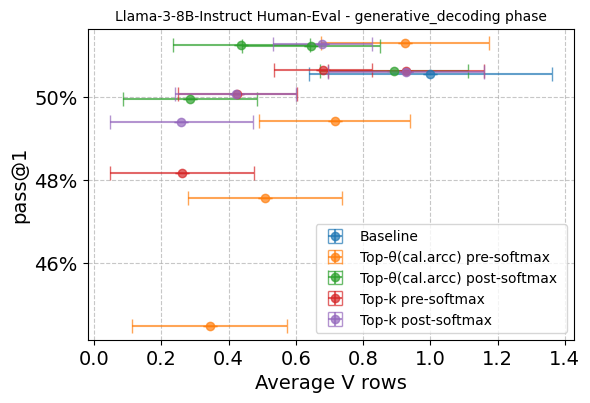

In [3]:
# plot generative decoding- scatterplts with errorbars
model_name = df_humaneval_generative_decoding.model_name.unique().item()
inference_phase = df_humaneval_generative_decoding.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_generative_decoding[df_humaneval_generative_decoding.label.str.startswith('Top-k') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Baseline') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ(cal.arcc)')], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type="errorbar",
                      rcParams_override={'legend.fontsize':10, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


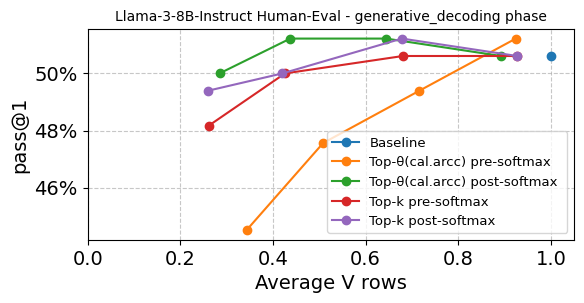

In [4]:
# plot generative decoding - line plots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_generative_decoding[df_humaneval_generative_decoding.label.str.startswith('Top-k') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Baseline') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ(cal.arcc)')], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type="line",
                      rcParams_override={'legend.fontsize':9.5, 'figure.figsize' : [6, 3],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


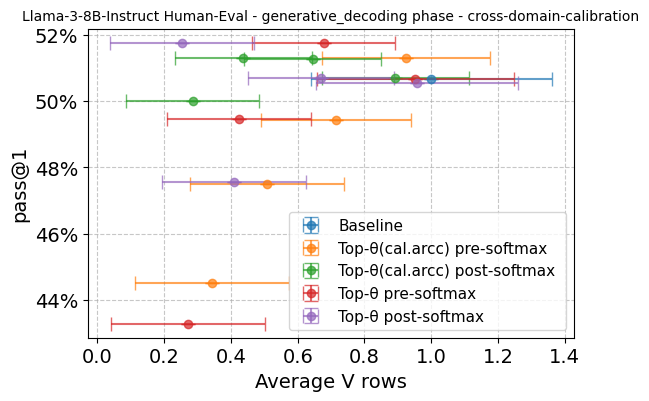

In [5]:
# plot generative decoding phase (with versus without loading thresholds) - scatterplot with errorbars
model_name = df_humaneval_generative_decoding.model_name.unique().item()
inference_phase = df_humaneval_generative_decoding.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase - cross-domain-calibration'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_generative_decoding[df_humaneval_generative_decoding.label.str.startswith('Baseline') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ ') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ(cal.arcc)')], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type="errorbar",
                      rcParams_override={'legend.fontsize':11, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


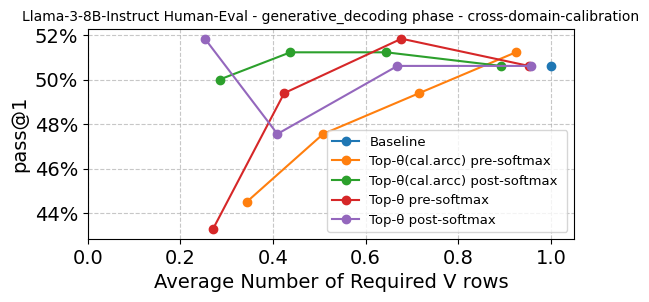

In [6]:
# plot generative decoding phase (with versus without loading thresholds) - lineplots
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_generative_decoding[df_humaneval_generative_decoding.label.str.startswith('Baseline') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ ') |
                                                       df_humaneval_generative_decoding.label.str.startswith('Top-θ(cal.arcc)')], 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average Number of Required", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type="line",
                      rcParams_override={'legend.fontsize':9.5, 'figure.figsize' : [6, 3],},
                      concise_labels=True)

In [7]:
# Re-read the list of results - this time for the prefill phase - focusing on "kept_attn" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="prefill"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_attn"

df_humaneval_prefill= aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


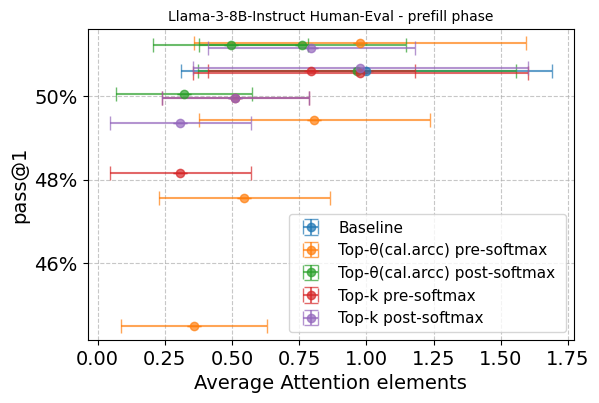

In [8]:
# plot prefill phase (with the capk) - scatterplot with errorbars
model_name = df_humaneval_prefill.model_name.unique().item()
inference_phase = df_humaneval_prefill.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_prefill[df_humaneval_prefill.label.str.startswith('Baseline') |
                                           df_humaneval_prefill.label.str.startswith('Top-k') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ(cal.arcc)')],                       
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':11, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


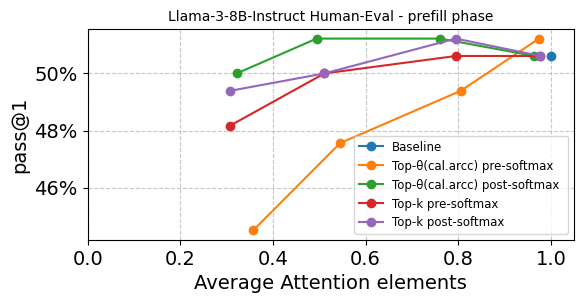

In [9]:
# plot prefill phase (with the capk) - lineplot
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_prefill[df_humaneval_prefill.label.str.startswith('Baseline') |
                                           df_humaneval_prefill.label.str.startswith('Top-k') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ(cal.arcc)')],                       
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type='line',
                      rcParams_override={'legend.fontsize':8.5, 'figure.figsize' : [6, 3],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


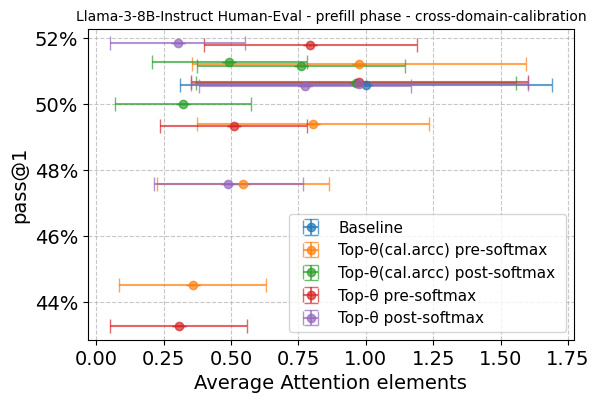

In [10]:
# plot prefill phase (with the capk) - scatterplot with errorbars
model_name = df_humaneval_prefill.model_name.unique().item()
inference_phase = df_humaneval_prefill.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase - cross-domain-calibration'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_humaneval_prefill[df_humaneval_prefill.label.str.startswith('Baseline') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ ') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ(cal.arcc)')],                       
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':11, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


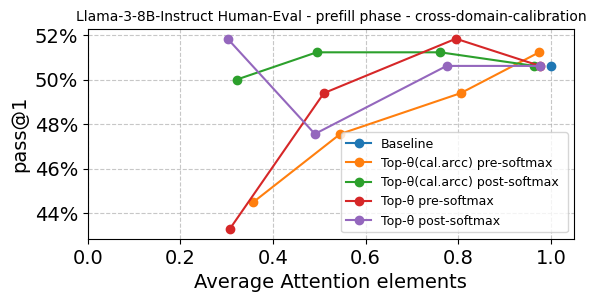

In [12]:
# plot prefill phase (with the capk) - lineplot
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_humaneval_prefill[df_humaneval_prefill.label.str.startswith('Baseline') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ ') |
                                           df_humaneval_prefill.label.str.startswith('Top-θ(cal.arcc)')],                       
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type='line',
                      rcParams_override={'legend.fontsize':9, 'figure.figsize' : [6, 3],},
                      concise_labels=True)

### LLaMA-3-70B-Instruct Human-Eval
The results should be on aime02

In [22]:
# Read a list of runs (each run is uniquely identified by a timestamp) and specify a label for each run as it should appear in the plot
RESULTS_META_LIST = [
    ResultMeta(timestamp='2025-01-06_15-53-03_097188', label='Baseline', k=999),
    ResultMeta(timestamp='2025-01-11_13-24-24_744355', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=16, ),
    ResultMeta(timestamp='2025-01-11_14-33-02_496092', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=32, ),
    ResultMeta(timestamp='2025-01-11_15-44-25_007971', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=64, ),
    ResultMeta(timestamp='2025-01-11_16-55-09_311344', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=128,),
    ResultMeta(timestamp='2025-01-11_18-04-13_018445', label='Top-θ(cal.arcc) pre-softmax + vmc + exact-sdc', k=256,),
    ResultMeta(timestamp='2025-01-11_19-11-42_559392', label='Top-θ(cal.arcc) post-softmax + vmc', k=16, ),
    ResultMeta(timestamp='2025-01-11_20-20-13_508087', label='Top-θ(cal.arcc) post-softmax + vmc', k=32, ),
    ResultMeta(timestamp='2025-01-11_21-27-46_357797', label='Top-θ(cal.arcc) post-softmax + vmc', k=64, ),
    ResultMeta(timestamp='2025-01-11_22-34-45_737100', label='Top-θ(cal.arcc) post-softmax + vmc', k=128,),
    ResultMeta(timestamp='2025-01-11_23-41-24_387510', label='Top-θ(cal.arcc) post-softmax + vmc', k=256,),    
    ResultMeta(timestamp='2025-01-09_08-07-06_996493', label='Top-k pre-softmax + vmc + exact-sdc',  k=16, ),
    ResultMeta(timestamp='2025-01-08_17-26-07_762757', label='Top-k pre-softmax + vmc + exact-sdc',  k=32, ),
    ResultMeta(timestamp='2025-01-08_18-22-17_481461', label='Top-k pre-softmax + vmc + exact-sdc',  k=64, ),
    ResultMeta(timestamp='2025-01-08_19-16-58_082715', label='Top-k pre-softmax + vmc + exact-sdc',  k=128,),
    ResultMeta(timestamp='2025-01-08_20-13-03_648289', label='Top-k pre-softmax + vmc + exact-sdc',  k=256,),
    ResultMeta(timestamp='2025-01-09_09-02-26_186332', label='Top-k post-softmax + vmc',  k=16, ),
    ResultMeta(timestamp='2025-01-08_21-06-32_826496', label='Top-k post-softmax + vmc',  k=32, ),
    ResultMeta(timestamp='2025-01-08_21-59-28_114845', label='Top-k post-softmax + vmc',  k=64, ),
    ResultMeta(timestamp='2025-01-08_22-52-47_341434', label='Top-k post-softmax + vmc',  k=128,),
    ResultMeta(timestamp='2025-01-08_23-46-16_322435', label='Top-k post-softmax + vmc',  k=256,),
]

# Read the list of results - for the generative_decoding phase - focusing on "kept_vrow" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="generative_decoding"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_vrow"

df_3_70i_humaneval_generative_decoding = aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


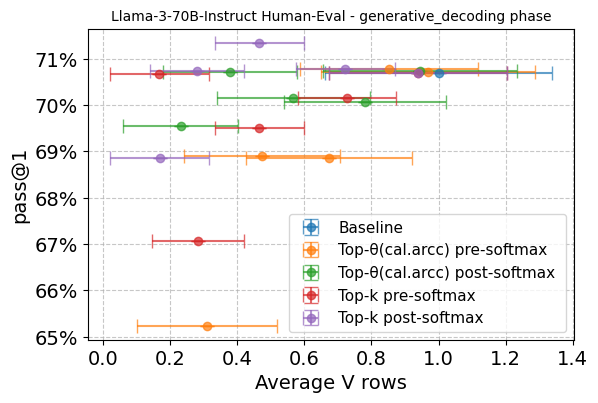

In [24]:
# plot generative decoding - scatterplot with errorbars
model_name = df_3_70i_humaneval_generative_decoding.model_name.unique().item()
inference_phase = df_3_70i_humaneval_generative_decoding.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_3_70i_humaneval_generative_decoding, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':11, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


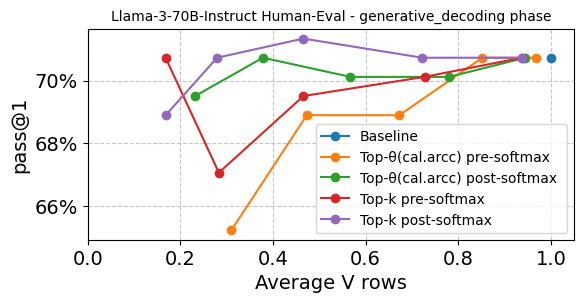

In [25]:
# plot generative decoding - scatterplot with errorbars
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_3_70i_humaneval_generative_decoding, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type='line',
                      rcParams_override={'legend.fontsize':10, 'figure.figsize' : [6, 3],},
                      concise_labels=True)

In [26]:
# Re-read the list of results - this time for the prefill phase - focusing on "kept_attn" metric
RESULTS_DIR_PATH = "../results-Llama"
PRODUCTS_DIR_PATH = "../products"
INFERENCE_PHASE="prefill"
ACCURACY_METRIC="pass@1"
SIZE_METRIC="kept_attn"

df_3_70i_humaneval_prefill= aggregate_accuracy_and_size_of_many_runs(RESULTS_META_LIST, ACCURACY_METRIC, SIZE_METRIC, INFERENCE_PHASE, RESULTS_DIR_PATH, PRODUCTS_DIR_PATH, num_cores=96)

Reading results in parallel using 96 parallel processes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


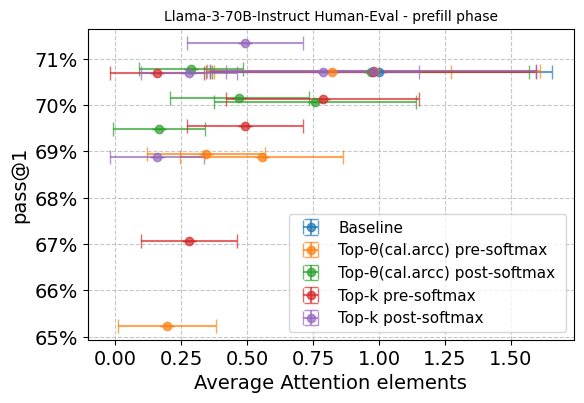

In [28]:
# plot prefill phase (with the capk) - scatterplot with errorbars
model_name = df_3_70i_humaneval_prefill.model_name.unique().item()
inference_phase = df_3_70i_humaneval_prefill.inference_phase.unique().item()
TITLE = f'{model_name} Human-Eval - {inference_phase} phase'
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff"
plot_accuracy_vs_size(df_3_70i_humaneval_prefill, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=False,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=True,
                      plot_type='errorbar',
                      rcParams_override={'legend.fontsize':11, 'figure.figsize' : [6, 4],},
                      concise_labels=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


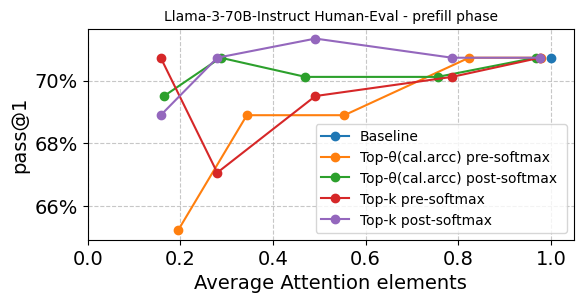

In [29]:
# plot prefill phase (with the capk) - scatterplot with errorbars
OUTPUT_DIR_PATH = "../figures/accuracy-kept_attn-kept_vrow-tradeoff-lineplots"
plot_accuracy_vs_size(df_3_70i_humaneval_prefill, 
                      TITLE, 
                      OUTPUT_DIR_PATH, 
                      full_xlim=True,
                      full_ylim=False,
                      normalize_size_by_fullsize=True,
                      x_label_prefix="Average", #"Average (across layers, heads, forward passes)",
                      accuracy_jitter=False,
                      plot_type='line',
                      rcParams_override={'legend.fontsize':10, 'figure.figsize' : [6, 3],},
                      concise_labels=True)